
## Futoshiki Solver

The project generates instances of the [Futoshiki](https://www.futoshiki.com/) puzzle and builds programs to solve it. A puzzle is instantiated as an object of the class `Futoshiki_puzzle`.

```python
P = Futoshiki_puzzle(n, S = None, C = None, U = None)
# n integer
# S, U are n x n integer matrices
# C is a list of pairs of tuples [[(i, j), (a, b)], ...]
```

**Parameters.** 
- `n`: denotes that the size of the puzzle is `n x n`.

- `U`: represents the unsolved state of the puzzle as an `n x n `matrix. `U` has entries in the set `{0, 1, ..., n}` where `0`s refer to hidden positions and every other entry is a revealed position. 

- `S`: solved state of the puzzle, that is, `S` agrees with `U` on the revealed positions, `S` is a latin square, and `S` satisfies the inequality constraints posed by `C`.

- `C`: a list of inequality constraints. If `[(i, j), (a, b)]` is in `C`, then `S[i, j] < S[a, b]`.

A puzzle can simply be generated by specifying `n`, eg. `P = Futoshiki_puzzle(n = 5)` and the rest of the paramteres can be generated by `P.Generate()`.

### Class Methods
```python
P.Generate(k = 3, r = 1)
# k, r integers
```
Post function call `P.S`, `P.U`, `P.C` are generated.

NOTE: the puzzles generated are not equipped to have unique solutions yet.

**Parameters.**
- `k`: the number of inequality constraints, or `len(C)`. The experiments are run with `k` roughly 30% of `n^2` (the number of entries in the grid).

- `r`: the number of revealed entries in the unsolved puzzle. In the experiments `r` is roughly 14% of `n^2`.


```python
P.Solve(algorithm = 'logic_solver')
# algorithm can also be 'logic_solver_deterministic', 'vanilla_backtrack'
```
Post function call the `algorithm` generates `P.S` as a function of `P.U` and `P.C`.

- `vanilla_backtrack` runs a brute force  seaerch algorithm on `P.U` to find `P.S` once all constraints are satisfied.

- `logic_solver` implements the logical techniques of elimination and insertion equipped with a backtracking strategy to find a solution with the minimum number of guesses. The solver is *randomized* in the sense that a guess is randomly picked from the logically possible values at any running state. The algorithm is briefly described in a later section _Brief Algorithm Description_.

- `logic_solver_deterministic` is a deterministic version of the above algorithm where the guesses are picked in ascending order.

`logic_solver` is significantly faster than `vanilla_backtrack`. A comparison graph is provided in the section _Speed Comparison_.

```python
P.Print(board = "both", inequalities = False)
# board can also be "unsolved" or "solved"
# inequalities can also be True
```
Prints the solved and the unsolved grid (or both), with or without the inequalities, as specified in the function call.

For example `P.Print(board = "unsolved", inequalities = True)` generates the following output. 
```
Unsolved puzzle: 

5  *  * > *  *
V     A      A
*  *  *   2  *
              
*  *  * < *  *
   A          
*  *  *   3  *
A  V      A   
*  2  *   *  1
```
Similarly, `P.Print(board = "solved", inequalities = False)` will output the following.
```
Solved puzzle: 

5 3 4 1 2
1 4 5 2 3
3 1 2 4 5
2 5 1 3 4
4 2 3 5 1
```
`P.Print()` also handles corner cases when the puzzle is not solved yet, or has no solution.

<hr>

### Brief Algorithm Descriptions

**Puzzle Generation approach.** \
Initially generate `P.S` as a [circulant matrix](https://en.wikipedia.org/wiki/Circulant_matrix) and shuffle its rows and columns. Randomly select `k` *consistent* index pairs in `P.C` as inequality constraints. Generate `P.U` as all zeros, and randomly select `r` *consistent* positions to agree with `P.S`. 

**Strategies behind logic_solver.** \
The game imposes two kinds of constraints on a puzzle `P`. First the `Line` constraints which ensure that the solve grid is a latin square, that is, in each row and each column there is exactly one occurence of the entry, and the `Inequality` constraints which are imposed by `P.C`. 

In the algorithm, first a residue grid `R` is generated which holds the list of values currently available to an index. The following is an example of the residue grid at an arbitrary running instance.

```
      5      3,4    2,3,4 >   1    2,3,4
      V                 A              A
  1,3,4  1,3,4,5    3,4,5     2    3,4,5
                                        
1,2,3,4    1,3,4  1,2,3,4 < 4,5  2,3,4,5
               A                        
  1,2,4      4,5  1,2,4,5     3    2,4,5
      A        V              A         
    3,4        2    3,4,5   4,5        1
```
Now each of two kinds of constraints can be used to employ two kinds of operations on `R`, they are `elimination` and `insertion`. `elimination` is when the current state of the grid renders some values impossible in some locations, and `insertion` is when the residue grid enforces a location to have a certain entry.

Based on these observations, the method `Logic_solver(U, C)` (refer to [logic_solver.py](logic_solver.py)) is supplied by the following helper functions:
- `Inequality_elimination` runs only once in the beginning. It goes through every inequality chain (including trivial ones) and eliminates impossible values. For example a chain like `* < * < *` in a `5 x 5` grid would imply that the first entry cannot be `4` or `5`.

- `Inequality_insertion` runs repeatedly in the algorithm. Goes through every inequality and checks if there is a unique pair in the residue grid `R` that satisfies it. If such a pair exists it enforces an insertion.

- `Line_elimination` runs initially on the revealed entries, and then runs repeatedly whenever a value is inserted or solved. For every solved entry it removes the entry from the residue in the row and column.

- `Line_insertion` runs throughout the program by going through unsolved indices in every row and column and checking if there is a unique residue, in which case an insertion is enforced. 

Once the puzzle is reduced with the above techniques, but still a complete solution cannot be enforced, we call the `Backtrack_on_residue` function. This is an updated backtracking method equipped with the above strategies so that the number of guesses can be minimized. The function (randomly or deterministically, as specified) inserts an guess from the possible values in the residue grid and immediately reduces the residue grid `R` using the above strategies, and calls itself recursively. If a solution is not reached it makes another guess. 

<hr>

### Speed comparison Logic_solver vs Vanilla_backtrack

The following bar graph provides a run time comparison of the `Logic_solver` algorithm with the `Vanilla_backtrack` algorithm. For each `n` in the set `{4, ..., 14}`, we generate `50` puzzles and solve each of them with the two algorithms. The puzzles are generated with `k` and `r` roughly 30% and 14% if `n^2`.

The bars denote how many of those puzzles ran within `5s` for each algorithm. On the head of each bar we print two more values. 

The `red` value indicates the average run time of the solver function for the `< 5s` runs. 

The `blue` value indicates the average number of guesses the algorithm had to make before reaching a solution, in multiples of `1000`.

 Note that for each `n`, the average is computed with different normalizers (height of the bar) for two solvers, as the number of `< 5s` runs are different. 

![test](performance_plot.png "Title")

The bar graph is generated by the file [performance_plot](performance_plot.py).
<hr>

### Future Work
1. Generate unique puzzles
2. Optimize the inequality chain finding algorithm.
3. Create a GUI to visualize the elimination and insertion techniques.
4. Create a GUI to play the puzzle with hints. 

In [6]:
# LOGIC OF INEQUALITY_INSERTION IS CHANGEED

# library imports
import random
import signal

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns

from copy import deepcopy
from scipy.linalg import circulant
from itertools import product
from time import time
from func_timeout import func_timeout

np.set_printoptions(legacy = '1.25')

In [7]:
def Find_maximal_chains(edges):
    ''' Given a directed graph defined by edges, find all non-trivial maximal chains. That is, 
    the graph induced by the edges should be separable into "maximal" chains, where maximal means 
    that the chain is not contained in any other chain. 
    '''
    if not edges: return []
    
    # Create directed graph
    G = nx.DiGraph()
    G.add_edges_from(edges)
    
    # Find all simple paths from source to sink nodes
    sources = [n for n, d in G.in_degree() if d == 0]
    sinks = [n for n, d in G.out_degree() if d == 0]
    
    all_chains = []
    for source in sources:
        for sink in sinks:
            # Find all simple paths between source and sink
            paths = nx.all_simple_paths(G, source, sink)
            for path in paths:
                if len(path) > 1:  # Only include chains with length > 1
                    all_chains.append(path)
    
    # Filter for maximal chains
    maximal_chains = []
    for chain in all_chains:
        is_maximal = True
        # simple n^2 comparison to check if chain is contained in any other chain
        # ?? Avenue for optimization 
        for other_chain in all_chains:
            if chain != other_chain and len(chain) < len(other_chain):
                # Check if chain is a subchain of other_chain
                chain_str = ''.join(map(str, chain))
                other_str = ''.join(map(str, other_chain))

                if chain_str in other_str:
                    is_maximal = False
                    break
                
        if is_maximal:
            maximal_chains.append(chain)
    
    return maximal_chains

In [8]:
def Random_index(n):
    '''returns a random index as a tuple (i, j) in a n x n grid.
    '''
    return tuple([np.random.randint(n) for _ in range(2)])

def Neighbors(index, n):
    '''returns the neighbours of a given index in a n x n grid.
    '''
    i, j = index
    # compute the neighbours of an index, which are indices on 
    # top, bottom, right and left
    neighbors = np.array([(i + 1, j), 
                          (i - 1, j), 
                          (i, j + 1), 
                          (i, j - 1)])
    
    # if the index is in the edge, we need to remove the neighbors that spill out of the grid
    neighbors = neighbors[[indicator[0] & indicator[1] 
                            for indicator in (neighbors >= 0) & (neighbors < n) ]]
    
    return [tuple(map(int, neighbor)) for neighbor in neighbors]

def Is_partial_latin_square(U):
    '''Check if the matrix U is a partial latin square. 
    Let U be n x n. Then U has integers entries in {0, 1, ..., n}. The 0s
    represent empty cells. The function returns True if the filled cells c
    can be completed to form a latin square. 
    '''

    n = U.shape[0]
    
    # principle: every row and column must have unique non-zero values, 
    # that is, the number of unique non-zero values must equal the number
    # of non-zero values.

    '''To achieve this we neeed a slightly modified count function
    Why? In an unfinished board, for any row or column u, 
        #nonzero(u) = #unique(u) - 1, 
    as 0 will also be a unique entry. But when the board is complete we will have 
        #nonzero(u) = #unique(u). 
    These two cases are captured in the updated count function below. 
    '''
    Count_nonzero = lambda x: min(np.count_nonzero(x) + 1, n)

    for i in range(n):
        # row check 
        if len(np.unique(U[i, :])) != Count_nonzero(U[i, :]): return False
        # column check
        elif len(np.unique(U[:, i])) != Count_nonzero(U[:, i]): return False
        
    return True


def Is_valid(U, C):
    '''Checks if the current state of the puzzle is valid.
    '''
    # check if at the current state the inequalities ar satisfied
    for index, neighbor in C:
        if U[index] != 0 and U[neighbor] != 0:
        # can compare only if both indices are filled
            if U[index] > U[neighbor]:
                return False

    # once the inequalities are satisfied, 
    # check if the puzzle is a partial latin square
    return Is_partial_latin_square(U)
    
def Is_complete(U):
    '''checks if the grid U is complete, that is it has no 0s.
    '''
    return np.count_nonzero(U) == U.size

def Vanilla_backtrack(U, C):
    '''Solves the puzzle U using the backtracking (vanilla) algorithm.
    '''
    n = U.shape[0]

    if not Is_valid(U, C): return False # puzzle cannot be solved with the current orientation
    if Is_complete(U): return U # puzzle is solved

    # find the next empty index
    index = np.unravel_index(np.argmin(U, axis = None), U.shape)

    for i in range(1, n + 1):
        # iterate through candidate values to fill in the empty index
        U[index] = i
        Vanilla_backtrack.calls += 1 # count how many guess insertions are made
        if Vanilla_backtrack(U, C) is not False: return Vanilla_backtrack(U, C)

    U[index] = 0 # backtracking step (the solver has not returned yet, or a solution 
    # has not beeen found). The the index is reset to be tacked by another call.
    return False

def Display_grid(U, C = None):
    '''Given a grid U and constraints C, this method returns the puzzle in 
    a readable string format.
    '''
    # printing the grid without the inequalities
    if C is None:
        return "\n" + pd.DataFrame(U).to_string(index = False, header = False) + "\n"

    n = U.shape[0]

    # make a grid of size (2n - 1) x (2n - 1) to make room for the inequalities
    Grid = np.array([[''] * (2*n - 1)] * (2*n - 1), dtype = "U" + str(2*n)) 

    # replace the unfilled cells marked as 0s with "*"s.
    U = U.astype(str); U[U == '0'] = '*'

    # fill the grid with entry from U
    Grid[::2, ::2] = U
    # fill the grid with the inequalities
    for index, neighbor in C:
        i, j = index
        p, q = neighbor

        if i == p: # row inequalities here
            Grid[2*i, min(j, q) * 2 + 1] = '<' if j < q else '>'
        
        elif j == q: # column inequalities here
            Grid[min(i, p) * 2 + 1, 2*j] = 'A' if i < p else 'V'

    # use DataFrame to format the grid to have correct alignment
    return "\n" + pd.DataFrame(Grid).to_string(index = False, header = False) + "\n"

In [9]:
class Futoshiki_puzzle:
    ''' Class attributes are initialized in __init__ method.
    '''
    def __init__(self, n = 5, 
                       S = None,
                       C = None,
                       U = None):
        
        # Class attributes
        self.n = n # size of the puzzle
        self.S = S # solved puzzle matrix (will be a latin square)
        self.C = C # list of inequalities
        self.U = U # unsolved puzzle

    def Generate_puzzle(self, k = 3,
                              r = 1):  
        '''Generates a puzzle of size n x n with k constraints and r pre-assigned cells.
        '''

        if self.S is None:
            # generate a circulant and permute its rows and columns
            S = circulant(np.array(range(1, self.n + 1)))
            np.random.shuffle(S); np.random.shuffle(S.T)
            # are there latin squares that are not permutations of the circulant? YES.

            self.S = S

        # generate k random constraints
        self.C = []
        pairs = [] # keep a track of pairs seen already, to ensure unique pairs

        while True: # keep generating until we have a valid set of constraints
            while len(pairs) < k:
                index = Random_index(self.n)
                # pick a random position from the neighbors
                neighbor = random.choice(Neighbors(index, self.n))
                
                # if pair is seen already, then skip
                if {index, neighbor} in pairs: continue

                pairs.append({index, neighbor})

                self.C.append([index, neighbor] if self.S[index] < self.S[neighbor] 
                                                else [neighbor, index])
            
            # there is an inequality cycle in the generated constraints. The puzzle may still 
            # have a solution, but we will like to avoid this situation.
            if nx.is_directed_acyclic_graph(nx.DiGraph(self.C)):
                break        

        # mask the solved puzzle, keeping only r (random) positions revealed
        revealed = []

        # simulating sampling with replacement, to ensure 
        # there are r unique positions 
        while len(set(revealed)) != r:
            revealed.append(Random_index(self.n))
        
        # the unsolved puzzle will have unrevealed positions masked as 0
        self.U = np.zeros((self.n, self.n), dtype = int)
        for index in revealed:
            self.U[index] = self.S[index]

        # ?? Check comptabitibility of revealed indices and inqualities -- both
        # sides of an inequality should not be revealed. Looks bad.  
    
    def Solve(self, algorithm = "logic_solver"):
        '''Solves the puzzle using the given algorithm.
        '''
        if algorithm == "vanilla_backtrack":
            self.S = Vanilla_backtrack(deepcopy(self.U), self.C)

        elif algorithm == "logic_solver":
            self.S = Logic_solver(deepcopy(self.U), self.C)

        elif algorithm == "logic_solver_deterministic":
            self.S = Logic_solver(deepcopy(self.U), self.C, randomize = False)
            
        else:
            raise ValueError("Algorithm not supported.")

    def Print(self, board = "both", inequalities = False):
        '''Prints the puzzle in a readable format.
        '''
        C = None # by default, no inequalities are printed
        if inequalities:
            C = self.C # print inequalities

        if board == "both" or board == "unsolved":
            # print unsolved puzzle
            if self.U is None: print("\nPuzzle not generated yet.")
            else: print("\nUnsolved puzzle: \n%s"%Display_grid(self.U, C))

        if board == "both" or board == "solved":
            # print solved puzzle
            if self.S is None: print("\nPuzzle not solved yet.")
            elif self.S is False: print("\nPuzzle is not solvable.")
            else: print("\nSolved puzzle: \n%s"%Display_grid(self.S, C))

In [10]:
def A2S(a):
    '''Converts an array to a comma separated string.
    '''
    return ','.join(map(str, a))

def S2A(s):
    '''Converts a comma separated string to an array.
    '''
    if s == '': return [] # empty string
    if ',' not in s: return [int(s)] # singleton 
    return list(map(int, s.split(',')))    
    
def Remove(s, val):
    '''Removes val from the string s. If val is in s it additionally returns -1, 
    if not it returns 0. (this function is a helper function to interact with 
    the Count matrix in Logic_solver)
    '''
    if val in S2A(s):
        return A2S(list(set(S2A(s)) - {val})), -1
    
    return s, 0

In [11]:
'''Solving strategies
1. Elimination 
    a) Inequality_elimination
    b) Line_elimination

2. Insertion
    a) Inequality_insertion
    b) Line_insertion
'''

def Pivot(Count):
    '''Given the Count array, it returns the location of the "pivot". A 
    pivot is a SOLVED index, that is Count[pivot] = 1. If pivot doesn't exist, 
    the function returns False.  
    '''
    index = np.unravel_index(np.argmin(Count), Count.shape)

    if Count[index] == 1: 
        return index # pivot is found

    if Count[index] > 1: 
        return None # the grid has no pivot
    
    if Count[index] < 1: 
        return False # grid is unsolvable

def Insert(R, Count, C, insertions):
    '''Given the grid info (R, Count, C) and a list of insertinos in the (index, value) format.
    This method will insert the values and update the grid, following by performing
    customary elimination and insertion steps.
    '''

    n = R.shape[0]

    # IMP: solved every index inserted by this method will have Count[index] = n + 1
    # this will be an important distinction between solved indices for which the grid has been
    # reduced to other solved indices (where Count[index] = 1) where reduction is pending
    
    for index, val in insertions:
        R[index] = str(val)
        Count[index] = n + 1 # solved index is inserted
        R, Count = Line_elimination(R, Count, C, pivot = index) 
        # Line_elimination has to be done for every insertion separately

    # conduct other reductions
    R, Count = Line_insertion(R, Count, C)
    R, Count = Inequality_insertion(R, Count, C)

    # the above reduction may have created new solved indices which need to inserted
    R, Count = Insert_all_pivots(R, Count, C)
    
    # IMP: once solved indices are inserted, they do not 
    # play a role in the future reductions.

    return R, Count

def Insert_all_pivots(R, Count, C):
    '''
    This function reduces the grid by continuously inserting solved indices
    until no more pivots can be found.
    '''
    pivot = Pivot(Count)
    while pivot:
        R, Count = Insert(R, Count, C, [(pivot, int(R[pivot]))])
        pivot = Pivot(Count)

    return R, Count

def Inequality_elimination(R, Count, C):
    '''Given the residue grid R, we first identify the chains formed by the inequalities. 
    This inlcludes the trivial chains of length 1, i.e. the inequalities themselves. 

    Now being a member of a chain renders some extremal values impossible. 
    For example, in the chain * < * < * < *, the last entry has to be larger than 4, and
    the first entry cannot be n. Such values are removed, and the updated grid is returned.

    This method only needs to be applied to the initial grid. 
    '''
    n = R.shape[0]

    # find all maximal chains (this is done by constructing a graph using the inequalities 
    # as the edge set and then surveying all the paths in the graph). 
    # Note, this step can be costly if len(C) is large. 
    chains = Find_maximal_chains(C)

    # for each chain eliminate the extremals
    for chain in chains:
        c = len(chain)
        for i in range(c):
            index = chain[i]

            # important step: the rule of exclusion is below, as the following must be satisfied
            # R[index] >= i + 1 and R[index] <= (n + 1) - (c - i) 
            for val in S2A(R[index]):
                if val < i + 1:
                    # eliminate exclusions enforced by '>'
                    # (this entry has to be larger than so many values)
                    R[index], count = Remove(R[index], val)
                    Count[index] += count

                if val > (n + 1) - (c - i):
                    # eliminate exclusions enforced by '<'
                    R[index], count = Remove(R[index], val)
                    Count[index] += count
                    
    return R, Count

def Line_elimination(R, Count, C, pivot):
    '''The method recursively reduces the rows and columns of a logic grid. The 
    solved position (pivot) is given, and this method removes the solved value
    from all the other entries in the row and column of the pivot.
    '''
    # stopping criteria
    if np.min(Count) < 1:
        # the grid is unsolvable. 
        return R, Count

    n = R.shape[0]

    i, j = pivot

    for l in range(n):
        # row reduce every entry except the pivot
        if l != j:
            R[i, l], count = Remove(R[i, l], int(R[i, j]))
            Count[i, l] += count
        # column reduce every entry except the pivot
        if l != i:
            R[l, j], count = Remove(R[l, j], int(R[i, j]))
            Count[l, j] += count
    
    return R, Count

def Line_insertion(R, Count, C):
    '''For every row and column collect the residues of all the unsolved indices. 
    If there is any value that appears only once in the logic, insert it in the 
    appropriate position. 
    '''

    n = R.shape[0]

    for i in range(n): # for ROWS
        if np.min(Count) < 1: return R, Count # grid is not solvable

        solved_values = [int(r) for r in R[i, : ] if ',' not in r]

        collection = [r for r in R[i, : ] if ',' in r]
        if len(collection) == 0: # all the indices are solved
            continue 
        
        # freq is a frequency array of the unsolved residues in the current row. 
        # The 0th entry is masked because 0 doesn't appear in the residue. 
        freq = np.bincount(S2A(','.join(collection)))
        freq[0] = n + 1 # remove from minimum computation

    
        for val in range(len(freq)):
            if freq[val] == 1 and val not in solved_values: # value is unique
                # and value is not already solved
                
                for j in range(n): # find the column index of val in residue R 
                    if val in S2A(R[i, j]): # index found
                        R, Count = Insert(R, Count, C, [((i, j), val)])
                        break

    for j in range(n): # for COLUMNS
        if np.min(Count) < 1: return R, Count # grid is not solvable
  
        solved_values = [int(r) for r in R[ : , j] if ',' not in r]
        
        # collect the residues of all the unsolved indices
        collection = [r for r in R[ : , j] if ',' in r]
        if len(collection) == 0: # all the indices are solved
            continue 

        # freq is a frequency array of the unsolved residues in the current column.
        # The 0th entry is masked because 0 doesn't appear in the residue.
        freq = np.bincount(S2A(','.join(collection)))
        freq[0] = n + 1 # remove from minimum computation
        
        for val in range(len(freq)):
            if freq[val] == 1 and val not in solved_values: # value is unique
                # and value is not already solved
                
                for i in range(n): # find the row index of val in residue R
                    if val in S2A(R[i, j]): # index found
                        R, Count = Insert(R, Count, C, [((i, j), val)])
                        # here is a prospective error of unwanted looping
                        # when REI is called from insert, it will get stuck here again
                        break

    return R, Count

def Inequality_insertion(R, Count, C):
    ''' This method goes through every constraint and forms satisfiability 
    pairs based on the current state of the residue grid. If the pair is
    unique, the method enforces an insertion.
    '''
    # stopping criteria
    if np.min(Count) < 1:
        # some index has no possible values
        return R, Count

    n = R.shape[0]

    for index, neighbor in C:
        # list of all pairs below
        all_pairs = list(product(S2A(R[index]), S2A(R[neighbor])))

        if len(all_pairs) == 1:
            if all_pairs[0][0] >= all_pairs[0][1]:
                # the inequality is satisfied
                R[index], R[neighbor] = '', ''
                Count[index], Count[neighbor] = 0, 0
                return R, Count

        if len(all_pairs) > 1: # ensuring that index and neighbor are not both solved
            # compute all valid pairs
            valid_pairs = [pair for pair in all_pairs if pair[0] < pair[1]]
            if len(valid_pairs) == 1:
                # insert when there is only one valid pair
                R, Count = Insert(R, Count, C, [(index, valid_pairs[0][0]),
                                                (neighbor, valid_pairs[0][1])])

    return R, Count

def Backtrack_on_residue(R, Count, C, randomize = True):
    ''' Solve the puzzle using a backtracking algorithm on the residue grid.'''
    
    n = R.shape[0]

    # stopping criteria
    if np.min(Count) < 1:
        # some index has no possible values
        return False, R, Count
    
    if np.min(Count) == n + 1:
        # all the indices are solved
        return True, R, Count
    
    # find an unsolved index with the smallest count (minimum possible values)
    index = np.unravel_index(np.argmin(Count), Count.shape)

    _R, _Count = deepcopy(R), deepcopy(Count)

    # possible values
    values = S2A(R[index])

    if randomize: np.random.shuffle(values)

    for val in values:
        # iterate through candidate values to fill in the empty index
        R, Count = Insert(R, Count, C, [(index, val)])
        Backtrack_on_residue.calls += 1 # count how many guess insertions are made

        # recursive call
        Bool, R, Count = Backtrack_on_residue(R, Count, C, randomize = randomize)
        if Bool: # a solution has been found
            return Bool, R, Count
        
        # the current val didn't lead to a solution. 
        # Try next val, but on the original residue grid
        R, Count = deepcopy(_R), deepcopy(_Count)   
        
    # backtracking step (the solver has not returned yet, or a solution
    # has not been found). The residue is reset to be tacked by another call.
    return False, _R, _Count

In [12]:
def Logic_solver(U, C, randomize = True):
    '''The logic solver will undergo the following checks to narrow 
    down the solution space. Once all the information is extracted, 
    a backtracking algorithm will run.
    '''

    n = U.shape[0]

    # RESIDUE GRID SETUP

    # R for "residue" will hold a list of all possible values available at each index 
    R = np.array([[A2S(list(range(1, n + 1)))] * n] * n)
    Count = np.array([[n] * n] * n)  # count of possible values at each index

    # update the revealed indices in the grid in the residue grid
    R[U != 0] = U[U != 0].astype(str)
    Count[U != 0] = 1 # solved indices will have Count = 1

    # # ___________________ ENFORCED CHECKS (insetions & eliminations)

    # 1. Inequality elimination
    R, Count = Inequality_elimination(R, Count, C)
    
    # 2. Line insertion
    R, Count = Line_insertion(R, Count, C)
    
    # 3. Inequality insertion
    R, Count = Inequality_insertion(R, Count, C)

    # 4. Line elimination only works when there are pivots
    R, Count = Insert_all_pivots(R, Count, C)

    if Pivot(Count) is False:
         # after reductions the residue at some index has become empty.
         # therefore the grid is unsolvable
         return False
    
    # print(Display_grid(R, C))
    # # _____________________ IMP: This is the furthest the Residue grid 
    # can be reduced! Beyond this point we will try to insert values 
    # and see if we reach a solution, using a backtracking algorithm.

    # Backtrack
    Bool, R, Count = Backtrack_on_residue(R, Count, C, randomize = randomize)
    
    # return solved grid by converting it to int, or False if the grid is unsolvable
    return R.astype(int) if Bool else False 

In [14]:
# Usage example
Backtrack_on_residue.calls = 0
Vanilla_backtrack.calls = 0

n = 7 # size of the puzzle
P = Futoshiki_puzzle(n = n)
# If the user doesn't want the puzzle to be generated, they can also 
# provide S, U, C in Futoshiki_puzzle(n, S = S, U = U, C = C) which represent
# the solved board, the unsolved baord and the constraints respectively.

# Generate a puzzle with k constraints and r pre-assigned cells
# This will generate P.S, P.U and P.C
P.Generate_puzzle(k = (n ** 2)//3, 
                  r = (n ** 2)//7)

# Print the solved board 
P.Print(board = "unsolved", inequalities = True)
# Print() can be called with board = "solved" or "unsolved" or "both", 
# and inequalities = True or False. 

P.Solve(algorithm = 'logic_solver')
# P.Solve() can be called wit algorithm = 'logic_solver_deterministic' or 'vanilla_backtrack'.

P.Print(board = "solved", inequalities = True)


Unsolved puzzle: 

* < *   *   *   *  *   2
    V                   
*   *   *   *   *  *   *
V       A               
*   * < *   *   *  *   *
                V       
*   5   *   * > *  *   *
            A          V
*   *   * < * > 2  *   1
V       A               
* > *   *   *   *  *   *
            A           
*   *   6   *   5  * < 4


Solved puzzle: 

4 < 6   3   5   1  7   2
    V                   
3   1   2   7   4  5   6
V       A               
1   3 < 4   2   7  6   5
                V       
6   5   1   4 > 3  2   7
            A          V
7   4   5 < 6 > 2  3   1
V       A               
5 > 2   7   1   6  4   3
            A           
2   7   6   3   5  1 < 4



In [ ]:
# !warning: this block can take upto 1 hour to run 

timeout = 5 # seconds
# n = 8
epochs = 50

# if you want to use previously generated data, uncomment the following lines, and comment the rest
'''
Data = [[[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 
         [0, 0, 0, 0, 0, 9, 17, 34, 42, 50, 49, 50, 50], 
         [0.0002466011047363281, 0.0006818532943725586, 0.0026663780212402345, 0.024431638717651367, 0.13658662319183348, 0.5506198871426466, 8.2687756653988, 1.5228297263383865, 2.617774486541748, np.inf, 2.765511989593506, np.inf, np.inf], 
         [7.92, 32.86, 148.48, 1539.9, 7884.54, 27064.024390243903, 53580.72727272727, 79258.9375, 166027.75, np.inf, 92104.0, np.inf, np.inf]],
        [[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 
         [0, 0, 0, 0, 0, 0, 6, 17, 23, 25, 41, 41, 44], 
         [0.00023950099945068359, 0.0005583477020263672, 0.0013272809982299806, 0.0033721303939819335, 0.0067474365234375, 0.053237590789794925, 0.1872912807898088, 0.2628524231188225, 0.2250267576288294, 0.47694902420043944, 0.3578384717305501, 0.5894114971160889, 2.400238275527954], 
         [0.0, 0.34, 2.18, 6.48, 12.24, 128.8, 386.02272727272725, 427.06060606060606, 282.037037037037, 472.24, 368.1111111111111, 395.55555555555554, 1490.8333333333333]]]

vanilla_info, logic_info = Data         
'''

vanilla_info = []
logic_info = []
False_count = 0


for n in range(2, 15):
    vanilla_times = []
    vanilla_calls = []

    logic_times = []
    logic_calls = []


    for _ in range(epochs):
        P = Futoshiki_puzzle(n = n)
        P.Generate_puzzle(k = (n ** 2)//3, r = (n ** 2)//7)

        Vanilla_backtrack.calls = 0
        P.S = None
        try:
            t = time()
            func_timeout(timeout, P.Solve, args = ("vanilla_backtrack",))
            vanilla_times.append(time() - t)
            vanilla_calls.append(Vanilla_backtrack.calls)
         
        except:
            vanilla_times.append(0)
            vanilla_calls.append(0)
        

        Backtrack_on_residue.calls = 0
        P.S = None
        try:
            t = time()
            func_timeout(timeout, P.Solve, args = ("logic_solver",))
            logic_times.append(time() - t)
            logic_calls.append(Backtrack_on_residue.calls)
    
            if P.S is False or Is_valid(P.S, P.C) is False:
                False_count += 1
        except:
            logic_times.append(0)
            logic_calls.append(0)
        
    vanilla_info.append((n, np.array(vanilla_times), np.array(vanilla_calls)))
    logic_info.append((n, np.array(logic_times), np.array(logic_calls)))

In [ ]:
def Extract_plottable_values(Data):
    '''Given a list of tuples (n, [(time, calls), ...]), 
    this function extracts the time and call values for plotting.
    '''
    X = []
    rate = []
    time = []
    calls = []
    epoch = len(Data[0][1])

    for data in Data:
        X.append(data[0])
        rate.append(np.sum(data[1] == 0))
        if epoch - rate[-1] == 0:
            time.append(np.inf)
            calls.append(np.inf)
            continue

        time.append(np.sum(data[1]) / (epoch - rate[-1]))
        calls.append(np.sum(data[2]) / (epoch - rate[-1]))
        
    return [X, rate, time, calls]

full_vanilla_data = Extract_plottable_values(vanilla_info)
full_logic_data = Extract_plottable_values(logic_info)

# remove the first two entries from every list in the data to avoid the trivial cases
vanilla_data = [None] * len(full_vanilla_data)
logic_data = [None] * len(full_logic_data)

for i in range(len(full_vanilla_data)):
    vanilla_data[i] = full_vanilla_data[i][2:]
    logic_data[i] = full_logic_data[i][2:]

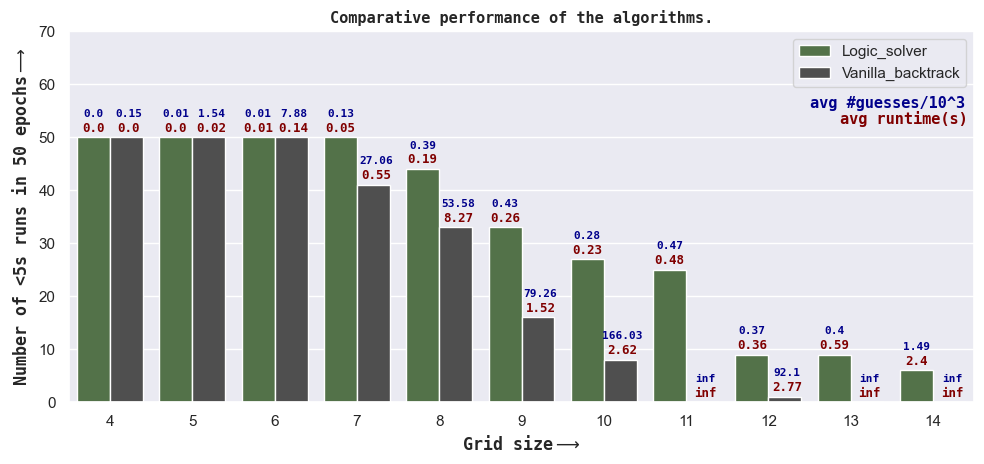

In [ ]:
# Plot vanilla and logic solver performance
X = vanilla_data[0]
N = len(vanilla_data[0])

alt_X = np.array([X, X]).T.flatten()
alt_failures = np.array([logic_data[1], vanilla_data[1]]).T.flatten()
alt_successes = 50 - alt_failures
alt_times = np.array([logic_data[2], vanilla_data[2]]).T.flatten().round(2)
alt_calls = (np.array([logic_data[3], vanilla_data[3]]).T.flatten()/1000).round(2)

plt.figure(figsize = (10, 4.8))

df = pd.DataFrame({
    'X' : alt_X,
    '# successes' : alt_successes,
    'Algo.': ['Logic_solver', 'Vanilla_backtrack'] * N,
})


sns.barplot(data = df, 
            x = 'X', 
            y = '# successes', 
            hue = 'Algo.', 
            palette = ['#4F7942', '#4F4F4F'],
            width = .8,)


plt.title('Comparative performance of the algorithms.', fontweight = 'bold', 
                                                        family = 'monospace', 
                                                        fontsize = 11)

plt.xlabel('Grid size' + r'$\longrightarrow$', fontweight = 'bold', 
                                               family = 'monospace')

plt.ylabel('Number of <5s runs in 50 epochs' + r'$\longrightarrow$', fontweight = 'bold', 
                                                                     family = 'monospace')

plt.tight_layout()
plt.ylim(0, 70) # increase y axis limit

# plot legends
plt.legend(loc = 'upper right')

plt.text(9.65, 52, 'avg runtime(s)', rotation = 'horizontal',
                                        ha = 'center', 
                                        va = 'bottom', 
                                        fontsize = 11,
                                        family = 'monospace',
                                        color = '#800000',
                                        fontstyle = 'normal',
                                        fontweight = 'bold',)

plt.text(9.45, 55, 'avg #guesses/10^3', rotation = 'horizontal',
                                        ha = 'center', 
                                        va = 'bottom', 
                                        fontsize = 11,
                                        family = 'monospace',
                                        color = '#00008B',
                                        fontstyle = 'normal',
                                        fontweight = 'bold',)

# plot run times and the number of calls in the bar graph
x_0, x_1  = -0.20, 0.23; parity = 0 # this values are particular to the plot and the configuration
x = x_0 
for index, value in enumerate(alt_successes):
    # plot run times of the two algorithms 
    plt.text(x, value + 0.5, str(alt_times[index]), rotation = 'horizontal', 
                                                        ha = 'center', 
                                                        va = 'bottom', 
                                                        fontsize = 9,
                                                        family = 'monospace',
                                                        color = '#800000',
                                                        fontstyle = 'normal',
                                                        fontweight = 'bold',)
    
    # plot number of calls of the two algorithms
    plt.text(x, value + 3.5, str(alt_calls[index]), rotation = 'horizontal',
                                                        ha = 'center', 
                                                        va = 'bottom', 
                                                        fontsize = 8,
                                                        family = 'monospace',
                                                        color = '#00008B',
                                                        fontstyle = 'normal',
                                                        fontweight = 'bold',)
    
    if parity == 0:
        x_0 += 1; parity = 1; x = x_1

    else:
        x_1 += 1; parity = 0; x = x_0

plt.savefig("performance_plot.png", dpi = 300, bbox_inches = 'tight')
plt.show()
